<a href="https://colab.research.google.com/github/rajuaddalaOracle/raddala/blob/master/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Future of Health Care- Disease Prediction
### BAX 423 Final Project 


### Installing & importing required packages

In [ ]:
# installing required packages
! pip install pyspark
! pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 31 kB/s 
     |████████████████████████████████| 198 kB 67.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=8453ea1db7b4b0ca08cc77a368dc8381d11ed146179a7e1f87c64e2adbc2d07f
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#importing required packages
from pyspark.sql import SparkSession
# importing to build a ML pipeline
from pyspark.ml import Pipeline
from pyspark.ml.feature import  VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# importing pandas and numpy to find corellations between variables
import pandas as pd
import numpy as np
# matplot lib
from matplotlib import pyplot as plt
#flask app
from flask_ngrok import run_with_ngrok
from flask import Flask
# grid search and hyper param tuning
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
 

### Creating a spark session

In [ ]:
# creating a spark session
spark = SparkSession.builder.appName('ml-project').getOrCreate()

### Loading the data

In [ ]:
# Linking google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Reading the data 
df = spark.read.csv("/content/drive/My Drive/heart_statlog_cleveland_hungary_final.csv", header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- chest pain type: integer (nullable = true)
 |-- resting bp s: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- fasting blood sugar: integer (nullable = true)
 |-- resting ecg: integer (nullable = true)
 |-- max heart rate: integer (nullable = true)
 |-- exercise angina: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- ST slope: integer (nullable = true)
 |-- target: integer (nullable = true)



In [ ]:
# Lets have a quick look into the data
df.show(5)

+---+---+---------------+------------+-----------+-------------------+-----------+--------------+---------------+-------+--------+------+
|age|sex|chest pain type|resting bp s|cholesterol|fasting blood sugar|resting ecg|max heart rate|exercise angina|oldpeak|ST slope|target|
+---+---+---------------+------------+-----------+-------------------+-----------+--------------+---------------+-------+--------+------+
| 40|  1|              2|         140|        289|                  0|          0|           172|              0|    0.0|       1|     0|
| 49|  0|              3|         160|        180|                  0|          0|           156|              0|    1.0|       2|     1|
| 37|  1|              2|         130|        283|                  0|          1|            98|              0|    0.0|       1|     0|
| 48|  0|              4|         138|        214|                  0|          0|           108|              1|    1.5|       2|     1|
| 54|  1|              3|         

### EDA

In [ ]:
# Summary of the data 
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,1190,53.72016806722689,9.358202797635384,28,77
sex,1190,0.7638655462184873,0.4248843096754766,0,1
chest pain type,1190,3.2327731092436975,0.9354803611453995,1,4
resting bp s,1190,132.15378151260504,18.36882341526594,0,200
cholesterol,1190,210.36386554621848,101.42048904518877,0,603
fasting blood sugar,1190,0.2134453781512605,0.40991175684733056,0,1
resting ecg,1190,0.6983193277310924,0.870358837985284,0,2
max heart rate,1190,139.7327731092437,25.51763554898286,60,202
exercise angina,1190,0.3873949579831933,0.4873599295179118,0,1


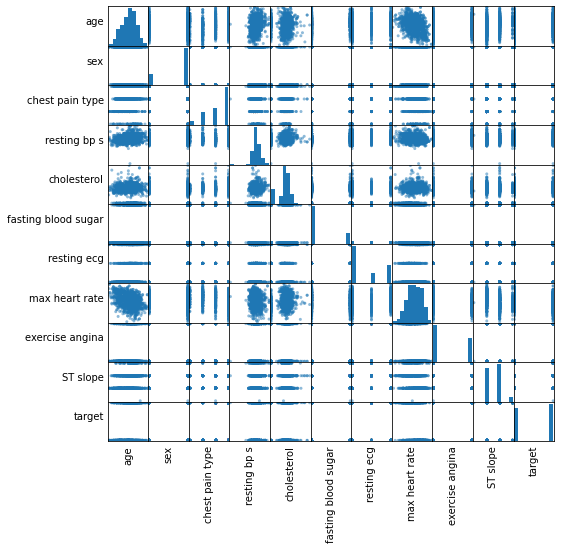

In [ ]:
# Lets check the corellation between variables
# a plot of distributions
numeric_data = df.select(numeric_features).toPandas()
axs = pd.plotting.scatter_matrix(numeric_data, figsize=(8, 8));
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

### Data Prepatation

**Note**
* All the categorical variables are already encoded using one-hot encoding, so we dont need to clean those.

In [ ]:
# Columns names in the test data set
column_names =  df.columns
column_names.pop()
column_names

['age',
 'sex',
 'chest pain type',
 'resting bp s',
 'cholesterol',
 'fasting blood sugar',
 'resting ecg',
 'max heart rate',
 'exercise angina',
 'oldpeak',
 'ST slope']

In [ ]:
# creating stages for the pipeline
stages=[]
assembler = VectorAssembler(inputCols=column_names, outputCol="features")
stages += [assembler]

### ML pipeline

In [ ]:
# Creating a pipeline for the ML model
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)

In [ ]:
# Selecting required columns
selectedCols = ['target','features'] + column_names
df = df.select(selectedCols)
df.printSchema()

root
 |-- target: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- chest pain type: integer (nullable = true)
 |-- resting bp s: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- fasting blood sugar: integer (nullable = true)
 |-- resting ecg: integer (nullable = true)
 |-- max heart rate: integer (nullable = true)
 |-- exercise angina: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- ST slope: integer (nullable = true)



In [ ]:
df.show(5)

+------+--------------------+---+---+---------------+------------+-----------+-------------------+-----------+--------------+---------------+-------+--------+
|target|            features|age|sex|chest pain type|resting bp s|cholesterol|fasting blood sugar|resting ecg|max heart rate|exercise angina|oldpeak|ST slope|
+------+--------------------+---+---+---------------+------------+-----------+-------------------+-----------+--------------+---------------+-------+--------+
|     0|[40.0,1.0,2.0,140...| 40|  1|              2|         140|        289|                  0|          0|           172|              0|    0.0|       1|
|     1|[49.0,0.0,3.0,160...| 49|  0|              3|         160|        180|                  0|          0|           156|              0|    1.0|       2|
|     0|[37.0,1.0,2.0,130...| 37|  1|              2|         130|        283|                  0|          1|            98|              0|    0.0|       1|
|     1|[48.0,0.0,4.0,138...| 48|  0|         

### Train - Test split

In [ ]:
# Doing a test/train split
train, test = df.randomSplit([0.7, 0.3], seed = 28)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 841
Test Dataset Count: 349


# Logistic regression

In [ ]:
# Creating a logistic regression and training 
lr = LogisticRegression(featuresCol = 'features', labelCol = 'target', maxIter=100)
lrModel = lr.fit(train)

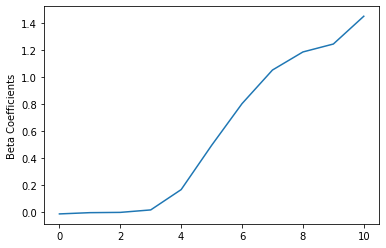

In [ ]:
#coefficients of the independent variables
beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


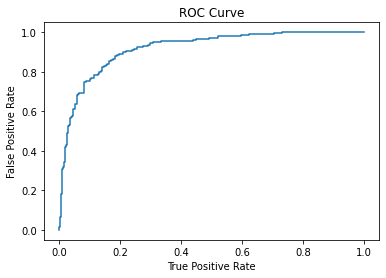

Training set areaUnderROC: 0.9181281256364434


In [ ]:
# ROC curve
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


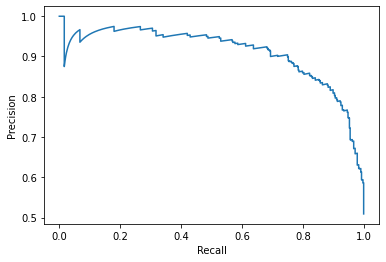

In [ ]:
# Precision vs recall curve 
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [ ]:
# Predictions
predictions = lrModel.transform(test)
predictions.show(10)

+------+--------------------+---+---+---------------+------------+-----------+-------------------+-----------+--------------+---------------+-------+--------+--------------------+--------------------+----------+
|target|            features|age|sex|chest pain type|resting bp s|cholesterol|fasting blood sugar|resting ecg|max heart rate|exercise angina|oldpeak|ST slope|       rawPrediction|         probability|prediction|
+------+--------------------+---+---+---------------+------------+-----------+-------------------+-----------+--------------+---------------+-------+--------+--------------------+--------------------+----------+
|     0|(11,[0,1,2,3,7,10...| 51|  1|              4|         128|          0|                  0|          0|           107|              0|    0.0|       1|[0.06705584947196...|[0.51675768361304...|       0.0|
|     0|(11,[0,2,3,4,7,10...| 32|  0|              2|         105|        198|                  0|          0|           165|              0|    0.0|   

In [ ]:
# Area under the ROC
evaluator = BinaryClassificationEvaluator( labelCol= 'target')
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 0.8738402581686164


In [ ]:
# Creating predictions
y_pred = predictions.select('prediction')
y_test = predictions.select('target')

In [ ]:
# Evaluating the model (recall, precision and acurracy )
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
predictionAndTarget = lrModel.transform(df).select("target", "prediction")

predictionAndTarget = np.array((predictionAndTarget.collect()))

acc = accuracy_score(predictionAndTarget[:,0], predictionAndTarget[:,1])
f1 = f1_score(predictionAndTarget[:,0], predictionAndTarget[:,1])
precision = precision_score(predictionAndTarget[:,0], predictionAndTarget[:,1])
recall = recall_score(predictionAndTarget[:,0], predictionAndTarget[:,1])

print("Accuracy - ", acc)
print("Precision - ", precision)
print("Recall - ", recall)
print("F1 Score - ", f1)

Accuracy -  0.83109243697479
Precision -  0.8462783171521036
Recall -  0.8314785373608903
F1 Score -  0.8388131515637531


# Decision Tree

In [ ]:
# Instantiating a Decision tree and training it
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'target', maxDepth = 5)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.show(10)

+------+--------------------+---+---+---------------+------------+-----------+-------------------+-----------+--------------+---------------+-------+--------+-------------+--------------------+----------+
|target|            features|age|sex|chest pain type|resting bp s|cholesterol|fasting blood sugar|resting ecg|max heart rate|exercise angina|oldpeak|ST slope|rawPrediction|         probability|prediction|
+------+--------------------+---+---+---------------+------------+-----------+-------------------+-----------+--------------+---------------+-------+--------+-------------+--------------------+----------+
|     0|(11,[0,1,2,3,7,10...| 51|  1|              4|         128|          0|                  0|          0|           107|              0|    0.0|       1|    [1.0,7.0]|       [0.125,0.875]|       1.0|
|     0|(11,[0,2,3,4,7,10...| 32|  0|              2|         105|        198|                  0|          0|           165|              0|    0.0|       1|  [246.0,9.0]|[0.96470

In [ ]:
# Area under the ROC
evaluator = BinaryClassificationEvaluator( labelCol= 'target')
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.8224418448299046


In [ ]:
# Evaluating the model on metrics such as Accuracy, precision and recall
predictionAndTarget = dtModel.transform(df).select("target", "prediction")

predictionAndTarget = np.array((predictionAndTarget.collect()))

acc = accuracy_score(predictionAndTarget[:,0], predictionAndTarget[:,1])
f1 = f1_score(predictionAndTarget[:,0], predictionAndTarget[:,1])
precision = precision_score(predictionAndTarget[:,0], predictionAndTarget[:,1])
recall = recall_score(predictionAndTarget[:,0], predictionAndTarget[:,1])

print("Accuracy - ", acc)
print("Precision - ", precision)
print("Recall - ", recall)
print("F1 Score - ", f1)

Accuracy -  0.8613445378151261
Precision -  0.8741935483870967
Recall -  0.8616852146263911
F1 Score -  0.8678943154523618


# Random Forest

In [ ]:
# Instantiating and training the Rando forest model 
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'target')
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.show(10)

+------+--------------------+---+---+---------------+------------+-----------+-------------------+-----------+--------------+---------------+-------+--------+--------------------+--------------------+----------+
|target|            features|age|sex|chest pain type|resting bp s|cholesterol|fasting blood sugar|resting ecg|max heart rate|exercise angina|oldpeak|ST slope|       rawPrediction|         probability|prediction|
+------+--------------------+---+---+---------------+------------+-----------+-------------------+-----------+--------------+---------------+-------+--------+--------------------+--------------------+----------+
|     0|(11,[0,1,2,3,7,10...| 51|  1|              4|         128|          0|                  0|          0|           107|              0|    0.0|       1|[13.4979703035884...|[0.67489851517942...|       0.0|
|     0|(11,[0,2,3,4,7,10...| 32|  0|              2|         105|        198|                  0|          0|           165|              0|    0.0|   

In [ ]:
# Area under the ROC curve 
evaluator = BinaryClassificationEvaluator( labelCol= 'target', metricName="recall" )
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9115066559096408


In [ ]:
# Evaluating the model on different paramets such as Accuracy, precison, recall
predictionAndTarget = rfModel.transform(df).select("target", "prediction")

predictionAndTarget = np.array((predictionAndTarget.collect()))

acc = accuracy_score(predictionAndTarget[:,0], predictionAndTarget[:,1])
f1 = f1_score(predictionAndTarget[:,0], predictionAndTarget[:,1])
precision = precision_score(predictionAndTarget[:,0], predictionAndTarget[:,1])
recall = recall_score(predictionAndTarget[:,0], predictionAndTarget[:,1])

print("Accuracy - ", acc)
print("Precision - ", precision)
print("Recall - ", recall)
print("F1 Score - ", f1)

Accuracy -  0.8781512605042017
Precision -  0.878125
Recall -  0.8934817170111288
F1 Score -  0.8857368006304176


## Grid search

In [ ]:
# Doing a Grid search to acheive better recall performance
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

rfc_gs = RandomForestClassifier(featuresCol = 'features', labelCol = 'target')

paramGrid = ParamGridBuilder() \
    .addGrid(rfc_gs.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rfc_gs.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()
stages_new=[]
pipeline_new = Pipeline(stages =stages_new ) 
crossval = CrossValidator( estimator=pipeline_new,
    estimatorParamMaps=paramGrid, 
    evaluator=RegressionEvaluator(labelCol= 'target'), 
                          numFolds=1)  
cvModel = crossval.fit(train)

In [ ]:
# Tuning the model 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
evaluator = BinaryClassificationEvaluator(labelCol = 'target')
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'target')
paramGrid = (ParamGridBuilder()
            .addGrid(rf.numTrees,  [int(x) for x in np.linspace(start = 10, stop = 200, num = 5)])
             .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 5)])
             .addGrid(rf.impurity, ['entropy','gini'])
             .addGrid(rf.featureSubsetStrategy, ['auto', 'sqrt'])
             .addGrid(rf.bootstrap, [True, False])
             .build())
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.9655102864058087

In [ ]:
# Pulling out the best model out of it
temp_temp = list(zip(cvModel.avgMetrics, paramGrid))
sorted(temp_temp, key = lambda x : x[0], reverse = True)[0]

(0.9556687800599277,
 {Param(parent='RandomForestClassifier_fc225eda857d', name='bootstrap', doc='Whether bootstrap samples are used when building trees.'): False,
  Param(parent='RandomForestClassifier_fc225eda857d', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 'n' (when n is in the range (0, 1.0], use n * number of features. When n is in the range (1, number of features), use n features). default = 'auto'"): 'auto',
  Param(parent='RandomForestClassifier_fc225eda857d', name='impurity', doc='Criterion used for information gain calculation (case-insensitive). Supported options: entropy, gini'): 'gini',
  Param(p

In [ ]:
# Predicting using the best random forest model
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'target',maxBins=10,maxDepth=25, numTrees=50 )
rfModel = rf.fit(train)
predictions = rfModel.transform(test)
predictions.show(10)

+------+--------------------+---+---+---------------+------------+-----------+-------------------+-----------+--------------+---------------+-------+--------+--------------------+--------------------+----------+
|target|            features|age|sex|chest pain type|resting bp s|cholesterol|fasting blood sugar|resting ecg|max heart rate|exercise angina|oldpeak|ST slope|       rawPrediction|         probability|prediction|
+------+--------------------+---+---+---------------+------------+-----------+-------------------+-----------+--------------+---------------+-------+--------+--------------------+--------------------+----------+
|     0|(11,[0,1,2,3,7,10...| 51|  1|              4|         128|          0|                  0|          0|           107|              0|    0.0|       1|[25.7489004699268...|[0.51497800939853...|       0.0|
|     0|(11,[0,2,3,4,7,10...| 32|  0|              2|         105|        198|                  0|          0|           165|              0|    0.0|   

In [ ]:
# Predictions from the best model 
predictionAndTarget = rfModel.transform(test).select("target", "prediction")
predictionAndTarget = np.array((predictionAndTarget.collect()))
acc = accuracy_score(predictionAndTarget[:,0], predictionAndTarget[:,1])
f1 = f1_score(predictionAndTarget[:,0], predictionAndTarget[:,1])
precision = precision_score(predictionAndTarget[:,0], predictionAndTarget[:,1])
recall = recall_score(predictionAndTarget[:,0], predictionAndTarget[:,1])

print("Accuracy - ", acc)
print("Precision - ", precision)
print("Recall - ", recall)
print("F1 Score - ", f1)

Precision :  0.9156626506024096
Accuracy :  0.9328859060402684
F1 score :  0.9382716049382716
recall :  0.9620253164556962


# Gradient boosted trees

In [ ]:
# Also going with Gradient boosting algorithm, just to see if you can find any better solution 
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'target',maxIter=10)
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)
predictions.show(10)

+------+--------------------+---+---+---------------+------------+-----------+-------------------+-----------+--------------+---------------+-------+--------+--------------------+--------------------+----------+
|target|            features|age|sex|chest pain type|resting bp s|cholesterol|fasting blood sugar|resting ecg|max heart rate|exercise angina|oldpeak|ST slope|       rawPrediction|         probability|prediction|
+------+--------------------+---+---+---------------+------------+-----------+-------------------+-----------+--------------+---------------+-------+--------+--------------------+--------------------+----------+
|     0|(11,[0,1,2,3,7,10...| 51|  1|              4|         128|          0|                  0|          0|           107|              0|    0.0|       1|[-0.4748947032534...|[0.27892717600186...|       1.0|
|     0|(11,[0,2,3,4,7,10...| 32|  0|              2|         105|        198|                  0|          0|           165|              0|    0.0|   

In [ ]:
# Area under the ROC curve 
evaluator = BinaryClassificationEvaluator(labelCol= 'target')
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9172381336560441


In [ ]:
# Evaluating the model
predictionAndTarget = gbtModel.transform(df).select("target", "prediction")

predictionAndTarget = np.array((predictionAndTarget.collect()))

acc = accuracy_score(predictionAndTarget[:,0], predictionAndTarget[:,1])
f1 = f1_score(predictionAndTarget[:,0], predictionAndTarget[:,1])
precision = precision_score(predictionAndTarget[:,0], predictionAndTarget[:,1])
recall = recall_score(predictionAndTarget[:,0], predictionAndTarget[:,1])

print("Accuracy - ", acc)
print("Precision - ", precision)
print("Recall - ", recall)
print("F1 Score - ", f1)

Accuracy -  0.9100840336134454
Precision -  0.9027777777777778
Recall -  0.9300476947535771
 F1 Score -  0.9162098668754894


## Grid search for gradient boosted trees

In [ ]:
# grid search for gradient boosted treest]
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
cvModel = cv.fit(train)
predictions = cvModel.transform(test)
evaluator.evaluate(predictions)

0.916851553045583

In [ ]:
# best model
temp_temp = list(zip(cvModel.avgMetrics, paramGrid))
sorted(temp_temp, key = lambda x : x[0], reverse = True)[0]

(0.9265273947241967,
 {Param(parent='GBTClassifier_967a2630e637', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 60,
  Param(parent='GBTClassifier_967a2630e637', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 4,
  Param(parent='GBTClassifier_967a2630e637', name='maxIter', doc='max number of iterations (>= 0).'): 20})

In [ ]:
# predictions from the best model 
gbt = GBTClassifier(featuresCol = 'features', labelCol = 'target',maxIter=20,maxBins=60, maxDepth=4 )
gbtModel = gbt.fit(train)
predictions = gbtModel.transform(test)

predictionAndTarget = rfModel.transform(test).select("target", "prediction")
predictionAndTarget = np.array((predictionAndTarget.collect()))
acc = accuracy_score(predictionAndTarget[:,0], predictionAndTarget[:,1])
f1 = f1_score(predictionAndTarget[:,0], predictionAndTarget[:,1])
precision = precision_score(predictionAndTarget[:,0], predictionAndTarget[:,1])
recall = recall_score(predictionAndTarget[:,0], predictionAndTarget[:,1])

print("Accuracy - ", acc)
print("Precision - ", precision)
print("Recall - ", recall)
print("F1 Score - ", f1)

Accuracy -  0.9025787965616046
Precision -  0.9195979899497487
Recall -  0.9104477611940298
F1 Score -  0.9149999999999999


# Deployment
* We are planning to deploy the model as a SaaS tool, so that people can use this directly as a website without any specific data science or ML idea

In [ ]:
# HTML template that has to be deployed
ftp = open("main.html","w+")
ftp.write("""<!doctype html>
<html>
<head>
<meta name="viewport" content="width=device-width">
<style type="text/css">
    html {
  height: 100%;
}
body {
  margin:0;
  padding:0;
  font-family: sans-serif;
  background: linear-gradient(#141e30, #243b55);
}

.login-box {
  position: absolute;
  top: 50%;
  left: 50%;
  botton:10%;
  width: 500px;
  height: 900px;
  padding: 40px;
  transform: translate(-50%, -50%);
  background: rgba(0,0,0,.5);
  box-sizing: border-box;
  box-shadow: 0 15px 25px rgba(0,0,0,.6);
  border-radius: 10px;
}

.login-box h2 {
  margin: 0 0 15px;
  padding: 0;
  color: #fff;
  text-align: center;
}

.login-box .user-box {
  position: relative;
}

.login-box .user-box input {
  width: 100%;
  padding: 10px 0;
  font-size: 10px;
  color: #fff;
  margin-bottom: 25px;
  border: none;
  border-bottom: 1px solid #fff;
  outline: none;
  background: transparent;
}
.login-box .user-box label {
  position: absolute;
  top:0;
  left: 0;
  padding: 10px 0;
  font-size: 15px;
  color: #fff;
  pointer-events: none;
  transition: .5s;
}

.login-box .user-box input:focus ~ label,
.login-box .user-box input:valid ~ label {
  top: -20px;
  left: 0;
  color: #03e9f4;
  font-size: 12px;
}

.login-box form a {
  position: relative;
  display: inline-block;
  padding: 10px 20px;
  color: #03e9f4;
  font-size: 16px;
  text-decoration: none;
  text-transform: uppercase;
  overflow: hidden;
  transition: .5s;
  margin-top: 40px;
  letter-spacing: 4px
}

.d {
  background-color: #03e9f4; /* Green */
  border: none;
  color: white;
  padding: 10px 40px;
  text-align: center;
  text-decoration: none;
  display: inline-block;
  font-size: 16px;
  border-radius: 12px;
}

.d:hover {
  background: #03e9f4;
  color: #fff;
  border-radius: 5px;
  box-shadow: 0 0 5px #03e9f4,
              0 0 25px #03e9f4,
              0 0 50px #03e9f4,
              0 0 100px #03e9f4;
}



.login-box a span {
  position: absolute;
  display: block;
}

.login-box a span:nth-child(1) {
  top: 0;
  left: -100%;
  width: 100%;
  height: 2px;
  background: linear-gradient(90deg, transparent, #03e9f4);
  animation: btn-anim1 1s linear infinite;
}

@keyframes btn-anim1 {
  0% {
    left: -100%;
  }
  50%,100% {
    left: 100%;
  }
}

.login-box a span:nth-child(2) {
  top: -100%;
  right: 0;
  width: 2px;
  height: 100%;
  background: linear-gradient(180deg, transparent, #03e9f4);
  animation: btn-anim2 1s linear infinite;
  animation-delay: .25s
}

@keyframes btn-anim2 {
  0% {
    top: -100%;
  }
  50%,100% {
    top: 100%;
  }
}

.login-box a span:nth-child(3) {
  bottom: 0;
  right: -100%;
  width: 100%;
  height: 2px;
  background: linear-gradient(270deg, transparent, #03e9f4);
  animation: btn-anim3 1s linear infinite;
  animation-delay: .5s
}

.label {
  color: white;
}
.label_result {
  color: white;
  font-size:30px;
  text-align: right;
  padding: 0 130px;
}

.label_result_1 {
  color: white;
  font-size:20px;
  text-align: right;
  padding: 0 130px;
}
.select {
  height: 25px;
}


@keyframes btn-anim3 {
  0% {
    right: -100%;
  }
  50%,100% {
    right: 100%;
  }
}

.login-box a span:nth-child(4) {
  bottom: -100%;
  left: 0;
  width: 2px;
  height: 100%;
  background: linear-gradient(360deg, transparent, #03e9f4);
  animation: btn-anim4 1s linear infinite;
  animation-delay: .75s
}

@keyframes btn-anim4 {
  0% {
    bottom: -100%;
  }
  50%,100% {
    bottom: 100%;
  }
  
}



</style>
</head>
<body>
<div class="login-box">
<br>
<br>
<br>
<br>
<br>
<br>
  <h2>Heart Risk Prediction</h2>
  <form action="{{ url_for('main') }}" method="POST">
    <div class="user-box">
      <input type="number" name="age" required="">
      <label>Age</label>
    </div>
<div class="user-box">
      <input type="number" name="resting_bp" required="">
      <label>Resting Blood Pressure (in mm Hg)</label>
    </div>
<div class="user-box">
      <input type="number" name="cholesterol" required="">
      <label>Cholesterol (in mg/dl)</label>
    </div>
<div class="user-box">
      <input type="number" name="heart_rate" required="">
      <label>Max Heart Rate</label>
    </div>
<div class="user-box">
      <input type="number" name="oldpeak" required="">
      <label>OldPeak (ST Depression)</label>
    </div>
<div>
<label for="gender" class="label">Sex  </label>
<select name="sex" id="gender" class="select">
    <option value="1">Male</option>
    <option value="0">Female</option>
    </select>
    <br>
<br>
<label for="fbs" class="label">Fasting Blood Sugar</label>
<select name="fasting_blood_sugar" id="fbs" class="select">
    <option value="1"> > 120 mg/dl</option>
    <option value="0"> &#60= 120 mg/dl</option>
    </select>
<br>
<br>
<label for="cp" class="label">Chest Pain</label>
<select name="chest_pain_type" id="cp" class="select">
    <option value="4">Asymptomatic</option>
    <option value="3">Non-Anginal Pain</option>
<option value="2">Atypical Angina</option>
    <option value="1">Typical Angina</option>
    </select>
<br>
<br>
<label for="ecg" class="label">Resting ECG</label>
<select name="ecg" id="ecg" class="select">
    <option value="0">Normal</option>
    <option value="1">Have ST - T Wave Abnormality</option>
    <option value="2">Probable/Definite Left Ventricular Hypertrophy</option>
    </select>
<br>
<br>
<label for="hrde" class="label">Heart Rate During Exercise</label>
<select name="ST_slope" id="hrde" class="select">
    <option value="1">Increasing</option>
    <option value="2">Constant</option>
    <option value="3">Decreasing</option>
    </select>
<br>
    <br>
<label for="exan" class="label">Exercise Angina</label>
<select name="exercise" id="exan" class="select">
    <option value="1">Yes</option>
    <option value="0">No</option>
    </select>
<br>
<br>
<br>
        <input class='d' type="submit">
        <br>
        <br>
        <br>
    {% if result %}
  <!--     {% for variable, value in original_input.items() %}
            <b class='label_result_1'>{{ variable }}</b> : {{ value }}
        {% endfor %} -->
           <b class='label_result'>{{ result }}</b>
    {% endif %}
</div>
  </form>
</body>
</html>
""")
ftp.close()

In [ ]:
# App to collect and return data, a python script that runs on the server, that constantly checks and replys
fpt = open("app.py","w+")
fpt.write("""import flask
import pickle
import pandas as pd

# Use pickle to load in the pre-trained model
with open(f'model/bike_model_xgboost.pkl', 'rb') as f:
    model = pickle.load(f)

# Initialise the Flask app
app = flask.Flask(__name__, template_folder='templates')

# Set up the main route
@app.route('/', methods=['GET', 'POST'])
def main():
    if flask.request.method == 'GET':
        # Just render the initial form, to get input
        return(flask.render_template('main.html'))
    
    if flask.request.method == 'POST':
        # Extract the input
        age = flask.request.form['age']
        sex = flask.request.form['sex']
        chest_pain_type = flask.request.form['chest_pain_type']
        resting_bp = flask.request.form['resting_bp']
        cholesterol = flask.request.form['cholesterol']
        fasting_blood_sugar = flask.request.form['fasting_blood_sugar']
        ecg = flask.request.form['ecg']
        heart_rate = flask.request.form['heart_rate']
        exercise = flask.request.form['exercise']
        oldpeak = flask.request.form['oldpeak']
        ST_slope = flask.request.form['ST_slope']
        # Make DataFrame for model
        input_variables = pd.DataFrame([[age, sex, chest_pain_type,resting_bp,cholesterol, fasting_blood_sugar,ecg,heart_rate,exercise, oldpeak,ST_slope ]],
                                       columns=['age', 'sex', 'chest_pain_type', 'resting_bp', 'cholesterol',
       'fasting_blood_sugar', 'ecg', 'heart_rate',
       'exercise', 'oldpeak', 'ST_slope'],
                                       dtype=float,
                                       index=['input'])

        # Get the model's prediction
        prediction = model.predict(input_variables)[0]
        
        if prediction ==0:
            prediction = "No Risk"
        else:
            prediction = "Risky"
        
        # Render the form again, but add in the prediction and remind user
        # of the values they input before

        return flask.render_template('main.html',
                                     original_input={'age':age , 'sex':sex, 'chest_pain_type':chest_pain_type
                                     , 'resting_bp':resting_bp, 'cholesterol':cholesterol,
       'fasting_blood_sugar':fasting_blood_sugar, 'ecg':ecg, 'heart_rate':heart_rate,
       'exercise':exercise, 'oldpeak':oldpeak, 'ST_slope':ST_slope},
                                     result=prediction,
                                     )

if __name__ == '__main__':
    app.run()""")
fpt.close()

### Deploy it on horuku 
* created a local git repo
* Created a new Heroku app
* pushed everything to heroku

Deployed at - https://shan-423-assignment-ucd.herokuapp.com/